# Example notebook to showcase the usage of the Poisson VAE model

We showcase the model on a 10X ATAC sample dataset. The data can be downloaded from [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard).

In [1]:
.libPaths(c('/home/icb/laura.martens/miniconda3/envs/archr/lib/R/library', '/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/lib/R/library'))

In [2]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
set.seed(1234)

Attaching SeuratObject

Attaching sp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: ‘IRanges’


The following object is masked from ‘package:sp’:

    %over%


Loading required package: ens

In [3]:
data_path <- '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data/10X/10k_Human_PBMCs_ATAC_v2_Chromium_Controller/'

## Pre-processing

We follow the original tutorial to create the Seurat object with ATAC data.

In [8]:
counts <- Read10X_h5(filename = paste0(data_path, "10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5"))

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



In [9]:
metadata <- read.csv(
  file = paste0(data_path, "10k_pbmc_ATACv2_nextgem_Chromium_Controller_singlecell.csv"),
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg38',
  fragments = paste0(data_path, '10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz'),
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [10]:
pbmc[['peaks']]

ChromatinAssay data with 165434 features for 10246 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

We add gene annotation information to facilitate downstream functionality.

In [11]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(pbmc) <- annotations

Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objec

## Computing QC metrics

We compute the same QC metrics as the [original tutorial](https://satijalab.org/signac/articles/pbmc_vignette.html#computing-qc-metrics-1). We leave it to the reader to follow the excellent Signac tutorial for understanding what these quantities represent.

In [12]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

In [13]:
# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [14]:
# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of blacklist_ratio."


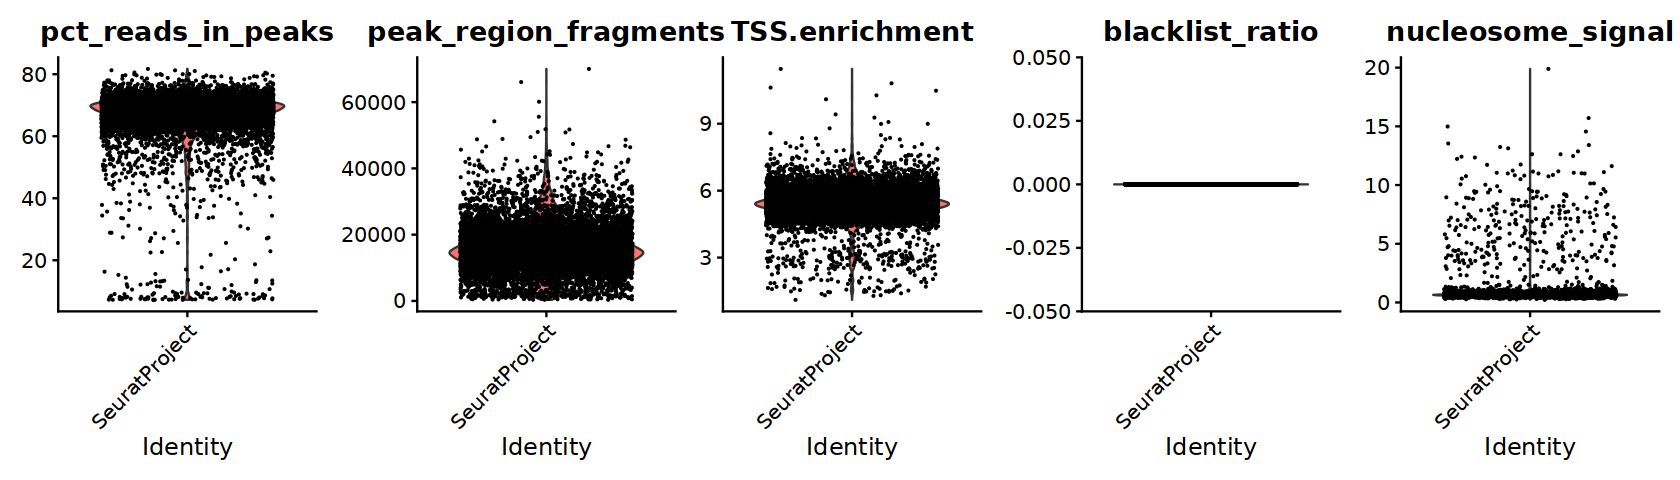

In [15]:
options(repr.plot.width=14, repr.plot.height=4)
VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [16]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 1000 &
    peak_region_fragments < 30000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
165434 features across 9597 samples within 1 assay 
Active assay: peaks (165434 features, 0 variable features)

## Dimensionality reduction (PoissonVAE)

### Creating an AnnData object

We follow the standard workflow for converting between Seurat and AnnData.

In [4]:
library(reticulate)
library(sceasy)
use_python("/home/icb/laura.martens/miniconda3/envs/scvi-tools-new/bin/python", required = TRUE)
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

Warning message:
"package 'sceasy' was built under R version 4.2.2"


In [17]:
adata <- convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", assay="peaks", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 9597 × 165434
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio'
    var: 'count', 'percentile'


### Run the standard PoissonVI workflow

In [24]:
scvi$data$reads_to_fragments(adata)

None

In [33]:
scvi$external$POISSONVI$setup_anndata(adata, layer='counts')

None

In [34]:
pvi <- scvi$external$POISSONVI(adata)

In [35]:
pvi$train(train_size=0.8, validation_size=0.1)

None

In [36]:
# get the latent represenation
latent = pvi$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
ndims <- ncol(latent)
pbmc[["poissonvi"]] <- CreateDimReducObject(embeddings = latent, key = "poissonvi_", assay = "peaks")

Warning message:
"No columnames present in cell embeddings, setting to 'poissonvi_1:20'"


In [37]:
5

[1] 5

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9597
Number of edges: 365391

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8743
Number of communities: 21
Elapsed time: 1 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
17:12:24 UMAP embedding parameters a = 0.9922 b = 1.112

17:12:24 Read 9597 rows and found 20 numeric columns

17:12:24 Using Annoy for neighbor search, n_neighbors = 30

17:12:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:12:25 Writing NN index file to temp file /tmp/RtmpvtdlN5/file34c8e4eb1caf8

17:12:25 Searching Annoy index using 1 thread, search_k = 3000

17:12:29 Annoy recall = 100%

17:12:31 Commencing smooth kNN distance calibration using 1 thread

17:12:35 Initializing fr

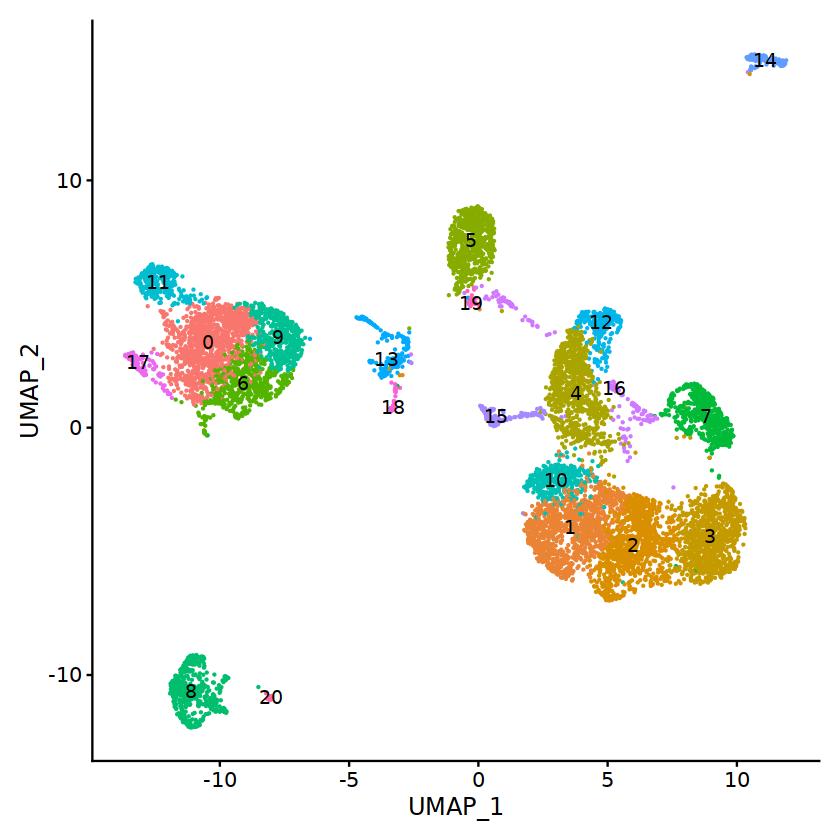

In [39]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, reduction = "poissonvi", dims=1:ndims)
pbmc <- FindClusters(pbmc, resolution = 1)

pbmc <- RunUMAP(pbmc, reduction = "poissonvi", dims=1:ndims)

options(repr.plot.width=7, repr.plot.height=7)
DimPlot(object = pbmc, label = TRUE) + NoLegend()

## Create a gene activity matrix

Important

The gene activity is used as an approximation of a gene expression matrix such that unpaired ATAC data can be integrated with RNA data. We recommend using this approach only for this unpaired case. Better results can be acheived if there is partially paired data.

In [40]:
gene.activities <- GeneActivity(pbmc)

# add the gene activity matrix to the Seurat object as a new assay and normalize it
pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
pbmc <- NormalizeData(
  object = pbmc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(pbmc$nCount_RNA)
)

Extracting gene coordinates

Extracting reads overlapping genomic regions



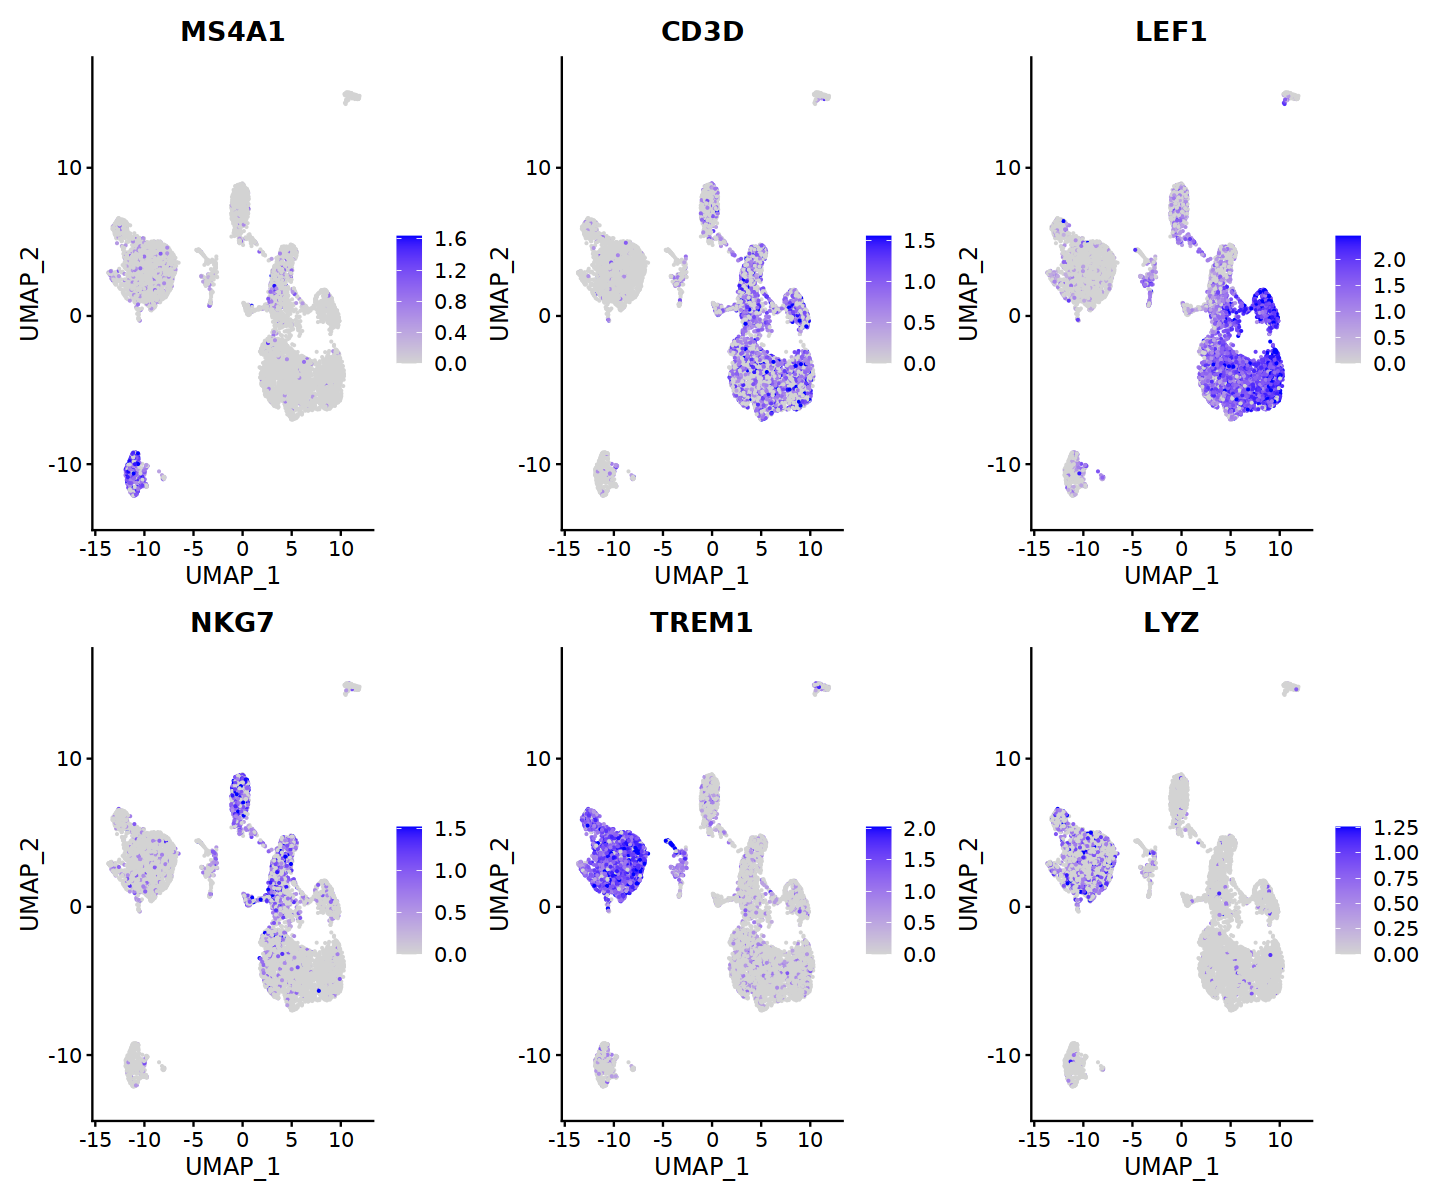

In [43]:
options(repr.plot.width=12, repr.plot.height=10)

DefaultAssay(pbmc) <- 'RNA'

FeaturePlot(
  object = pbmc,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

## Integrating with scRNA-seq data

We can integrate the gene activity matrix with annotated scRNA-seq data using different methods. Here we use CCA but you could also use SCANVI or scGLUE.

First we download the Seurat-processed PBMC 10k dataset (as in their tutorial). 

In [46]:
# Load the pre-processed scRNA-seq data for PBMCs
pbmc_rna <- readRDS("/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data/10X/RNA/pbmc_10k_v3.rds")

transfer.anchors <- FindTransferAnchors(
  reference = pbmc_rna,
  query = pbmc,
  reduction = 'cca'
)

In [54]:
predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = pbmc_rna$celltype,
  weight.reduction = pbmc[['poissonvi']],
  dims=1:20
)

pbmc <- AddMetaData(object = pbmc, metadata = predicted.labels)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



 Important

These labels should only serve as a starting point. Further inspection should always be performed. We leave this to the user, but will continue with these labels as a demonstration.


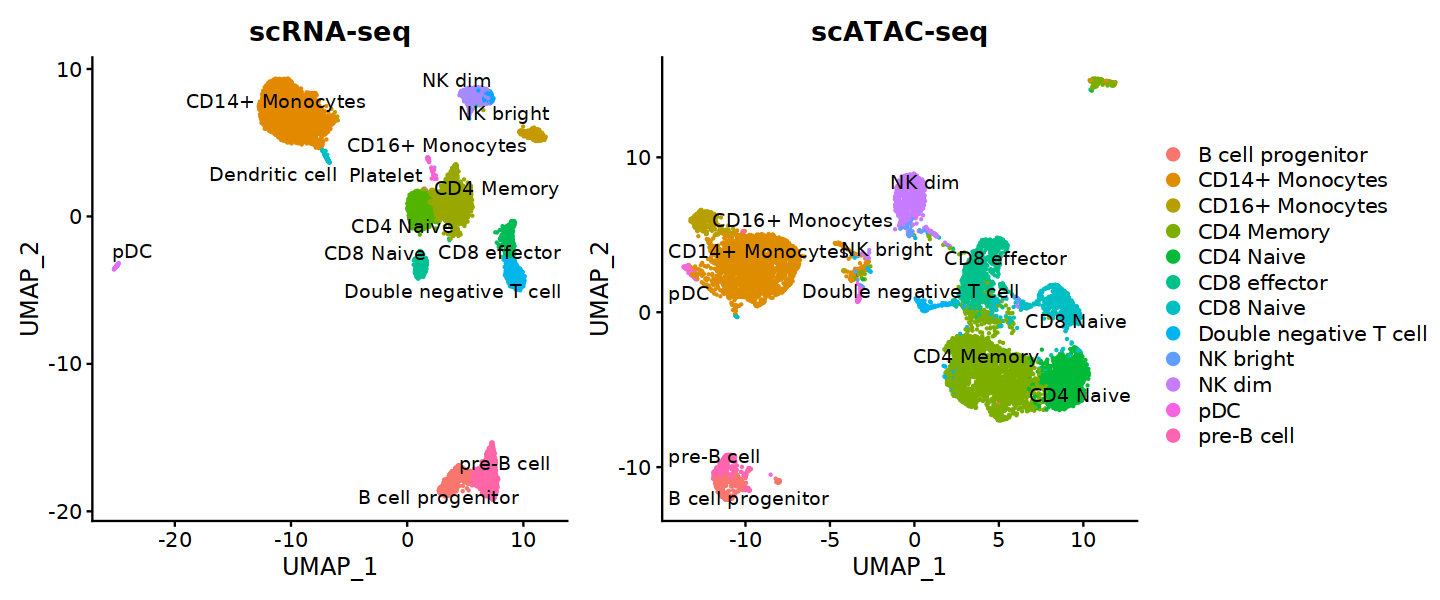

In [58]:
options(repr.plot.width=12, repr.plot.height=5)

plot1 <- DimPlot(
  object = pbmc_rna,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = pbmc,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + ggtitle('scATAC-seq')

plot1 + plot2

## Finding differentially accessible peaks between clusters
As PoissonVI learns uncertainty around the observed data, it can be leveraged for differential accessibility analysis. First, let's store the seurat cluster information back inside the AnnData.

In [60]:
adata$obs$insert(adata$obs$shape[1], "predicted_ct", pbmc[["predicted.id"]][,1])

None

Using our trained PoissonVI model, we call the differential_accessibility() (DA) method We pass predicted_ct to the groupby argument and compare between naive CD4 T cells and CD14 monocytes.

The output of DA is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posterior expected FDR.


In [61]:
DA <- pvi$differential_accessibility(adata, groupby="predicted_ct", group1 = "CD4 Naive", group2 = "CD14+ Monocytes")
DA <- py_to_r(DA)
head(DA)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,⋯,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
chr6-21856750-21857531,1,0,18.42068,2.511382e-07,1.719776e-05,0,0.25,-Inf,-6.609794,NaN,⋯,0.003039514,0.292817712,0.003039514,0.238844029,0.002222475,0.16432311,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes
chr10-15188504-15189229,1,0,18.42068,5.611634e-06,2.189517e-07,0,0.25,Inf,5.033422,NaN,⋯,0.069908820,0.003824905,0.065856130,0.003824904,0.058987238,0.00161830,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes
chr20-47975037-47975935,1,0,18.42068,6.384611e-07,1.567943e-05,0,0.25,-4.627374,-4.643856,0.8429028,⋯,0.007092199,0.265193403,0.007092199,0.217594560,0.005605315,0.14719343,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes
chr13-49642944-49643708,1,0,18.42068,6.051183e-07,7.900703e-06,0,0.25,-3.666841,-3.748938,0.7767345,⋯,0.012158055,0.158521041,0.010131712,0.135996600,0.010966148,0.08325921,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes
chr13-49641613-49642462,1,0,18.42068,5.285740e-07,2.316487e-05,0,0.25,-5.547868,-5.610762,0.7776667,⋯,0.007092199,0.411389768,0.007092199,0.308967276,0.006405728,0.22679766,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes
chr20-48712255-48713249,1,0,18.42068,4.371762e-07,2.750977e-05,0,0.25,-6.044871,-6.118940,0.6056112,⋯,0.003039514,0.472588241,0.003039514,0.340416490,0.003329335,0.25678802,TRUE,CD4 Naive vs CD14+ Monocytes,CD4 Naive,CD14+ Monocytes


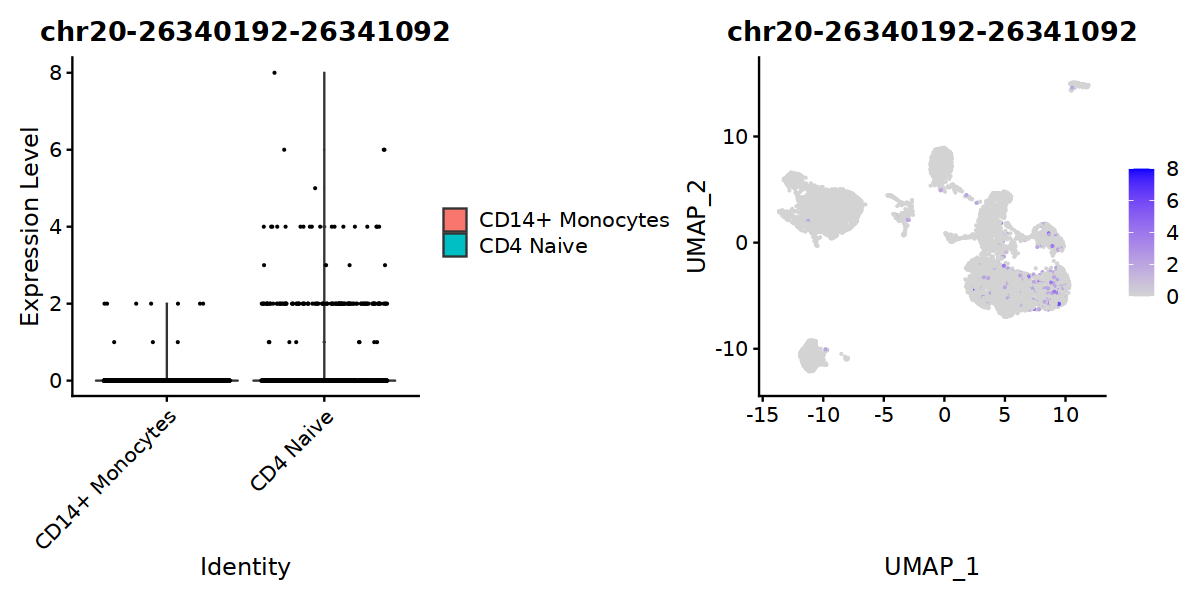

In [69]:
options(repr.plot.width=10, repr.plot.height=5)

DefaultAssay(pbmc) <- 'peaks'
Idents(pbmc) <- pbmc[["predicted.id"]]

plot1 <- VlnPlot(
  object = pbmc,
  features = rownames(DA)[3],
  pt.size = 0.1,
  idents = c("CD4 Naive","CD14+ Monocytes")
)
plot2 <- FeaturePlot(
  object = pbmc,
  features = rownames(DA)[3],
  pt.size = 0.1
)

plot1 | plot2

In [ ]:
saveRDS(pbmc, 'pbmc.rds')

In [5]:
pbmc <- readRDS('pbmc.rds')